# Efficient Machine Learning - Fine-grained and channel pruning
This notebook concerns the concept of neural network pruning. The concepts of fine-grained and channel pruning are implemented and tested. The performance improvements and differences and tradeoffs between these pruning approaches are compared

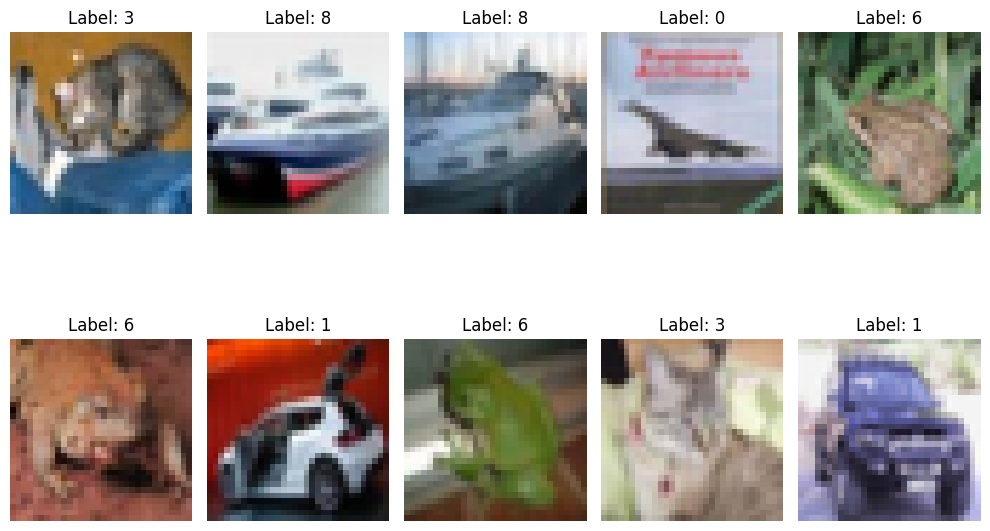

In [169]:
images, labels = next(iter(dataloader['test']))
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
for i in range(10):  # Displaying 10 images, adjust the range as needed
    plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns for 10 images
    plt.imshow(np.transpose(images[i], (1, 2, 0)))
    plt.axis('off')
    plt.title(f'Label: {labels[i]}')
    plt.tight_layout()

## EfficientML pruning techniques
The following section leverages the techniques outlined in Song Han's [TinyML and Efficient Deep Learning Computing Course at MIT](https://hanlab.mit.edu/courses/2023-fall-65940)


In [2]:
%pip install torchprofile

  Obtaining dependency information for torchprofile from https://files.pythonhosted.org/packages/62/15/71ad4ed163b03cba1315f1d96e0bc8e39d5a97f92974ffa610a729b273ab/torchprofile-0.0.4-py3-none-any.whl.metadata
  Obtaining dependency information for torch>=1.4 from https://files.pythonhosted.org/packages/35/3a/a39f354fa3119785be87e2f94ffa2620f8a270c8560f7356358ee62fb4c5/torch-2.3.0-cp311-cp311-manylinux1_x86_64.whl.metadata
  Obtaining dependency information for torchvision>=0.4 from https://files.pythonhosted.org/packages/6e/7d/bc67ec2d1011226e75cdcc45a2c85d97b8eaac32a7d648b71c432d584367/torchvision-0.18.0-cp311-cp311-manylinux1_x86_64.whl.metadata
  Obtaining dependency information for filelock from https://files.pythonhosted.org/packages/41/24/0b023b6537dfc9bae2c779353998e3e99ac7dfff4222fc6126650e93c3f3/filelock-3.14.0-py3-none-any.whl.metadata
  Obtaining dependency information for typing-extensions>=4.8.0 from https://files.pythonhosted.org/packages/01/f3/936e209267d6ef7510322191003

### Setup

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
import torch.nn as nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from torchvision.models import vgg16
from tqdm.auto import tqdm

# Ensure CUDA support
assert torch.cuda.is_available(), "The runtime has no CUDA support"

/home/ppst/Documents/agh/nn_pruning/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# setting seeds for reproducability
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [4]:
def download_url(url, model_dir='.', overwrite=False):
    import os, sys, ssl
    from urllib.request import urlretrieve
    ssl._create_default_https_context = ssl._create_unverified_context
    target_dir = url.split('/')[-1]
    model_dir = os.path.expanduser(model_dir)
    try:
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        model_dir = os.path.join(model_dir, target_dir)
        cached_file = model_dir
        if not os.path.exists(cached_file) or overwrite:
            sys.stderr.write('Downloading: "{}" to {}\n'.format(url, cached_file))
            urlretrieve(url, cached_file)
        return cached_file
    except Exception as e:
        # remove lock file so download can be executed next time.
        os.remove(os.path.join(model_dir, 'download.lock'))
        sys.stderr.write('Failed to download from url %s' % url + '\n' + str(e) + '\n')
        return None

In [5]:
class VGG(nn.Module):
  ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
  # ARCH =  [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"]

  def __init__(self) -> None:
    super().__init__()

    layers = []
    counts = defaultdict(int)

    def add(name: str, layer: nn.Module) -> None:
      layers.append((f"{name}{counts[name]}", layer))
      counts[name] += 1

    in_channels = 3
    for x in self.ARCH:
      if x != 'M':
        # conv-bn-relu
        add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
        add("bn", nn.BatchNorm2d(x))
        add("relu", nn.ReLU(True))
        in_channels = x
      else:
        # maxpool
        add("pool", nn.MaxPool2d(2))

    self.backbone = nn.Sequential(OrderedDict(layers))
    self.classifier = nn.Linear(512, 10)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
    x = self.backbone(x)

    # avgpool: [N, 512, 2, 2] => [N, 512]
    x = x.mean([2, 3])

    # classifier: [N, 512] => [N, 10]
    x = self.classifier(x)
    return x

In [6]:
model = VGG().cuda()

In [7]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

In [8]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

Helper Functions (Flops, Model Size calculation, etc.)

In [9]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

Define misc functions for verification.

In [10]:
def test_fine_grained_prune(
    test_tensor=torch.tensor([[-0.46, -0.40, 0.39, 0.19, 0.37],
                              [0.00, 0.40, 0.17, -0.15, 0.16],
                              [-0.20, -0.23, 0.36, 0.25, 0.03],
                              [0.24, 0.41, 0.07, 0.13, -0.15],
                              [0.48, -0.09, -0.36, 0.12, 0.45]]),
    test_mask=torch.tensor([[True, True, False, False, False],
                            [False, True, False, False, False],
                            [False, False, False, False, False],
                            [False, True, False, False, False],
                            [True, False, False, False, True]]),
    target_sparsity=0.75, target_nonzeros=None):
    def plot_matrix(tensor, ax, title):
        ax.imshow(tensor.cpu().numpy() == 0, vmin=0, vmax=1, cmap='tab20c')
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[1]):
            for j in range(tensor.shape[0]):
                text = ax.text(j, i, f'{tensor[i, j].item():.2f}',
                                ha="center", va="center", color="k")

    test_tensor = test_tensor.clone()
    fig, axes = plt.subplots(1,2, figsize=(6, 10))
    ax_left, ax_right = axes.ravel()
    plot_matrix(test_tensor, ax_left, 'dense tensor')

    sparsity_before_pruning = get_sparsity(test_tensor)
    mask = fine_grained_prune(test_tensor, target_sparsity)
    sparsity_after_pruning = get_sparsity(test_tensor)
    sparsity_of_mask = get_sparsity(mask)

    plot_matrix(test_tensor, ax_right, 'sparse tensor')
    fig.tight_layout()
    plt.show()

    print('* Test fine_grained_prune()')
    print(f'    target sparsity: {target_sparsity:.2f}')
    print(f'        sparsity before pruning: {sparsity_before_pruning:.2f}')
    print(f'        sparsity after pruning: {sparsity_after_pruning:.2f}')
    print(f'        sparsity of pruning mask: {sparsity_of_mask:.2f}')

    if target_nonzeros is None:
        if test_mask.equal(mask):
            print('* Test passed.')
        else:
            print('* Test failed.')
    else:
        if mask.count_nonzero() == target_nonzeros:
            print('* Test passed.')
        else:
            print('* Test failed.')

Load the pretrained model and the CIFAR-10 dataset.

In [11]:
checkpoint_url = "https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth"
checkpoint = torch.load(download_url(checkpoint_url), map_location="cpu")
model = VGG().cuda()
print(f"=> loading checkpoint '{checkpoint_url}'")
model.load_state_dict(checkpoint['state_dict'])
recover_model = lambda: model.load_state_dict(checkpoint['state_dict'])

=> loading checkpoint 'https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth'


In [12]:
image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": ToTensor(),
}
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

Files already downloaded and verified
Files already downloaded and verified


### Dense model accuracy and model size

In [12]:
model

VGG(
  (backbone): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (pool1): MaxPo

In [13]:
dense_model_accuracy = evaluate(model, dataloader['test'])
dense_model_size = get_model_size(model)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")

dense model has accuracy=92.95%
dense model has size=35.20 MiB


### Weight value distribution

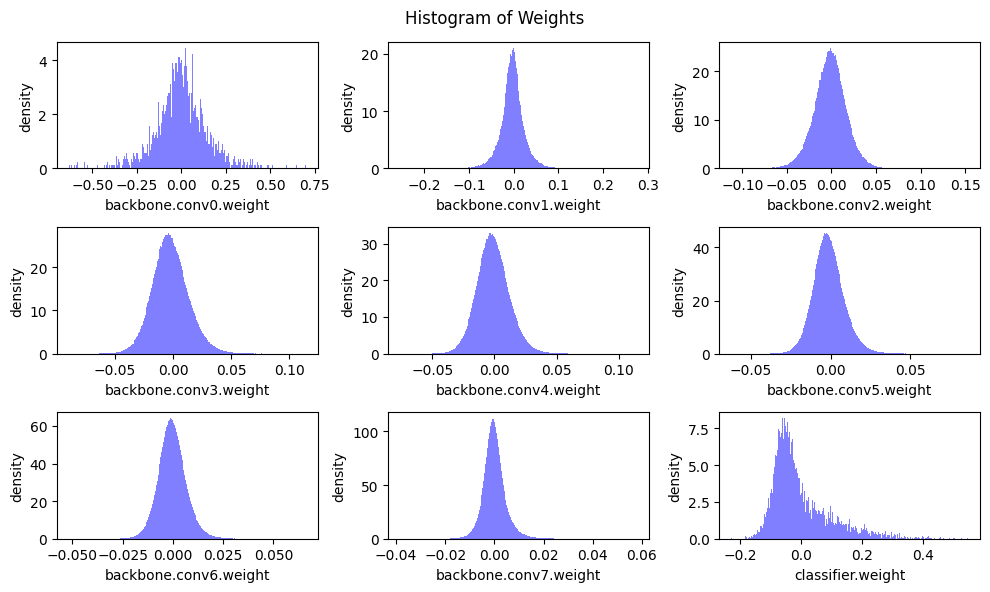

In [14]:
import matplotlib.pyplot as plt
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(3,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_weight_distribution(model)

### Fine-grained Pruning
Fine-grained pruning removes the synapses with the lowest importance. The weight vector $W$ will become sparse after fine-grained pruning.
In practice, given the target sparsity $s$, the weight tensor $W$ is multiplied with a binary mask $M$ to disregard removed weight:

> $v_{\mathrm{thr}} = \texttt{kthvalue}(Importance, \#W \cdot s)$
>
> $M = Importance > v_{\mathrm{thr}}$
>
> $W = W \cdot M$

where $Importance$ is importance tensor with the same shape of $W$, $\texttt{kthvalue}(X, k)$ finds the $k$-th smallest value of tensor $X$, $v_{\mathrm{thr}}$ is the threshold value.


#### Magnitude-based Pruning

In [15]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    # Step 1: calculate the #zeros (please use round())
    num_zeros = round(sparsity * num_elements)
    # Step 2: calculate the importance of weight
    importance = abs(tensor)
    # Step 3: calculate the pruning threshold
    threshold, _ = torch.kthvalue(importance.view(-1), num_zeros, dim=-1)
    # Step 4: get binary mask (1 for nonzeros, 0 for zeros)
    mask = importance > threshold
    # Step 5: apply mask to prune the tensor
    tensor.mul_(mask)

    return mask

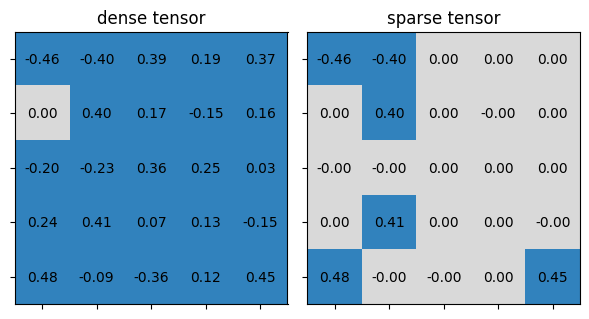

* Test fine_grained_prune()
    target sparsity: 0.75
        sparsity before pruning: 0.04
        sparsity after pruning: 0.76
        sparsity of pruning mask: 0.76
* Test passed.


In [16]:
test_fine_grained_prune()

In [17]:
# Class for pruning the whole model

class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks

#### Sensitivity Scan
Different layers contribute differently to the model performance. A sensitivity scan can be used to decide the proper sparity for each layer.

In [18]:
@torch.no_grad()
def sensitivity_scan(model, dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    named_conv_weights = [(name, param) for (name, param) \
                          in model.named_parameters() if param.dim() > 1]
    for i_layer, (name, param) in enumerate(named_conv_weights):
        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'scanning {i_layer}/{len(named_conv_weights)} weight - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)
            acc = evaluate(model, dataloader, verbose=False)
            if verbose:
                print(f'\r    sparsity={sparsity:.2f}: accuracy={acc:.2f}%', end='')
            # restore
            param.copy_(param_clone)
            accuracy.append(acc)
        if verbose:
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}%".format(x) for x in accuracy])}]', end='')
        accuracies.append(accuracy)
    return sparsities, accuracies

In [19]:
sparsities, accuracies = sensitivity_scan(
    model, dataloader['test'], scan_step=0.1, scan_start=0.4, scan_end=1.0)

scanning 0/9 weight - backbone.conv0.weight:  17%|██████                              | 1/6 [00:03<00:16,  3.22s/it]

    sparsity=0.40: accuracy=92.42%

scanning 0/9 weight - backbone.conv0.weight:  33%|████████████                        | 2/6 [00:06<00:12,  3.20s/it]

    sparsity=0.50: accuracy=91.19%

scanning 0/9 weight - backbone.conv0.weight:  50%|██████████████████                  | 3/6 [00:09<00:09,  3.20s/it]

    sparsity=0.60: accuracy=87.55%

scanning 0/9 weight - backbone.conv0.weight:  67%|████████████████████████            | 4/6 [00:12<00:06,  3.20s/it]

    sparsity=0.70: accuracy=83.39%

scanning 0/9 weight - backbone.conv0.weight:  83%|██████████████████████████████      | 5/6 [00:15<00:03,  3.19s/it]

    sparsity=0.80: accuracy=69.41%

scanning 0/9 weight - backbone.conv0.weight: 100%|████████████████████████████████████| 6/6 [00:19<00:00,  3.20s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.42%, 91.19%, 87.55%, 83.39%, 69.41%, 31.81%]

scanning 1/9 weight - backbone.conv1.weight:  17%|██████                              | 1/6 [00:03<00:15,  3.19s/it]

    sparsity=0.40: accuracy=92.93%

scanning 1/9 weight - backbone.conv1.weight:  33%|████████████                        | 2/6 [00:06<00:12,  3.19s/it]

    sparsity=0.50: accuracy=92.88%

scanning 1/9 weight - backbone.conv1.weight:  50%|██████████████████                  | 3/6 [00:09<00:09,  3.19s/it]

    sparsity=0.60: accuracy=92.71%

scanning 1/9 weight - backbone.conv1.weight:  67%|████████████████████████            | 4/6 [00:12<00:06,  3.19s/it]

    sparsity=0.70: accuracy=92.40%

scanning 1/9 weight - backbone.conv1.weight:  83%|██████████████████████████████      | 5/6 [00:15<00:03,  3.19s/it]

    sparsity=0.80: accuracy=91.32%

scanning 1/9 weight - backbone.conv1.weight: 100%|████████████████████████████████████| 6/6 [00:19<00:00,  3.19s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.93%, 92.88%, 92.71%, 92.40%, 91.32%, 84.78%]

scanning 2/9 weight - backbone.conv2.weight:  17%|██████                              | 1/6 [00:03<00:15,  3.20s/it]

    sparsity=0.40: accuracy=92.94%

scanning 2/9 weight - backbone.conv2.weight:  33%|████████████                        | 2/6 [00:06<00:12,  3.20s/it]

    sparsity=0.50: accuracy=92.64%

scanning 2/9 weight - backbone.conv2.weight:  50%|██████████████████                  | 3/6 [00:09<00:09,  3.20s/it]

    sparsity=0.60: accuracy=92.46%

scanning 2/9 weight - backbone.conv2.weight:  67%|████████████████████████            | 4/6 [00:12<00:06,  3.20s/it]

    sparsity=0.70: accuracy=91.77%

scanning 2/9 weight - backbone.conv2.weight:  83%|██████████████████████████████      | 5/6 [00:15<00:03,  3.20s/it]

    sparsity=0.80: accuracy=89.85%

scanning 2/9 weight - backbone.conv2.weight: 100%|████████████████████████████████████| 6/6 [00:19<00:00,  3.20s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.94%, 92.64%, 92.46%, 91.77%, 89.85%, 78.56%]

scanning 3/9 weight - backbone.conv3.weight:  17%|██████                              | 1/6 [00:03<00:16,  3.20s/it]

    sparsity=0.40: accuracy=92.86%

scanning 3/9 weight - backbone.conv3.weight:  33%|████████████                        | 2/6 [00:06<00:12,  3.20s/it]

    sparsity=0.50: accuracy=92.72%

scanning 3/9 weight - backbone.conv3.weight:  50%|██████████████████                  | 3/6 [00:09<00:09,  3.20s/it]

    sparsity=0.60: accuracy=92.23%

scanning 3/9 weight - backbone.conv3.weight:  67%|████████████████████████            | 4/6 [00:12<00:06,  3.20s/it]

    sparsity=0.70: accuracy=91.09%

scanning 3/9 weight - backbone.conv3.weight:  83%|██████████████████████████████      | 5/6 [00:15<00:03,  3.20s/it]

    sparsity=0.80: accuracy=85.35%

scanning 3/9 weight - backbone.conv3.weight: 100%|████████████████████████████████████| 6/6 [00:19<00:00,  3.20s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.86%, 92.72%, 92.23%, 91.09%, 85.35%, 51.31%]

scanning 4/9 weight - backbone.conv4.weight:  17%|██████                              | 1/6 [00:03<00:16,  3.20s/it]

    sparsity=0.40: accuracy=92.88%

scanning 4/9 weight - backbone.conv4.weight:  33%|████████████                        | 2/6 [00:06<00:12,  3.20s/it]

    sparsity=0.50: accuracy=92.68%

scanning 4/9 weight - backbone.conv4.weight:  50%|██████████████████                  | 3/6 [00:09<00:09,  3.20s/it]

    sparsity=0.60: accuracy=92.22%

scanning 4/9 weight - backbone.conv4.weight:  67%|████████████████████████            | 4/6 [00:12<00:06,  3.20s/it]

    sparsity=0.70: accuracy=89.47%

scanning 4/9 weight - backbone.conv4.weight:  83%|██████████████████████████████      | 5/6 [00:16<00:03,  3.20s/it]

    sparsity=0.80: accuracy=76.86%

scanning 4/9 weight - backbone.conv4.weight: 100%|████████████████████████████████████| 6/6 [00:19<00:00,  3.20s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.88%, 92.68%, 92.22%, 89.47%, 76.86%, 38.78%]

scanning 5/9 weight - backbone.conv5.weight:  17%|██████                              | 1/6 [00:03<00:16,  3.21s/it]

    sparsity=0.40: accuracy=92.92%

scanning 5/9 weight - backbone.conv5.weight:  33%|████████████                        | 2/6 [00:06<00:12,  3.21s/it]

    sparsity=0.50: accuracy=92.71%

scanning 5/9 weight - backbone.conv5.weight:  50%|██████████████████                  | 3/6 [00:09<00:09,  3.21s/it]

    sparsity=0.60: accuracy=92.63%

scanning 5/9 weight - backbone.conv5.weight:  67%|████████████████████████            | 4/6 [00:12<00:06,  3.21s/it]

    sparsity=0.70: accuracy=91.88%

scanning 5/9 weight - backbone.conv5.weight:  83%|██████████████████████████████      | 5/6 [00:16<00:03,  3.26s/it]

    sparsity=0.80: accuracy=89.90%

scanning 5/9 weight - backbone.conv5.weight: 100%|████████████████████████████████████| 6/6 [00:19<00:00,  3.23s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.92%, 92.71%, 92.63%, 91.88%, 89.90%, 82.19%]

scanning 6/9 weight - backbone.conv6.weight:  17%|██████                              | 1/6 [00:03<00:16,  3.21s/it]

    sparsity=0.40: accuracy=92.94%

scanning 6/9 weight - backbone.conv6.weight:  33%|████████████                        | 2/6 [00:06<00:12,  3.21s/it]

    sparsity=0.50: accuracy=92.86%

scanning 6/9 weight - backbone.conv6.weight:  50%|██████████████████                  | 3/6 [00:09<00:09,  3.21s/it]

    sparsity=0.60: accuracy=92.65%

scanning 6/9 weight - backbone.conv6.weight:  67%|████████████████████████            | 4/6 [00:12<00:06,  3.21s/it]

    sparsity=0.70: accuracy=92.10%

scanning 6/9 weight - backbone.conv6.weight:  83%|██████████████████████████████      | 5/6 [00:16<00:03,  3.21s/it]

    sparsity=0.80: accuracy=90.58%

scanning 6/9 weight - backbone.conv6.weight: 100%|████████████████████████████████████| 6/6 [00:19<00:00,  3.21s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.94%, 92.86%, 92.65%, 92.10%, 90.58%, 83.65%]

scanning 7/9 weight - backbone.conv7.weight:  17%|██████                              | 1/6 [00:03<00:16,  3.21s/it]

    sparsity=0.40: accuracy=92.94%

scanning 7/9 weight - backbone.conv7.weight:  33%|████████████                        | 2/6 [00:06<00:12,  3.21s/it]

    sparsity=0.50: accuracy=92.92%

scanning 7/9 weight - backbone.conv7.weight:  50%|██████████████████                  | 3/6 [00:09<00:09,  3.21s/it]

    sparsity=0.60: accuracy=92.88%

scanning 7/9 weight - backbone.conv7.weight:  67%|████████████████████████            | 4/6 [00:12<00:06,  3.21s/it]

    sparsity=0.70: accuracy=92.81%

scanning 7/9 weight - backbone.conv7.weight:  83%|██████████████████████████████      | 5/6 [00:16<00:03,  3.21s/it]

    sparsity=0.80: accuracy=92.63%

scanning 7/9 weight - backbone.conv7.weight: 100%|████████████████████████████████████| 6/6 [00:19<00:00,  3.21s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.94%, 92.92%, 92.88%, 92.81%, 92.63%, 91.34%]

scanning 8/9 weight - classifier.weight:  17%|██████▋                                 | 1/6 [00:03<00:15,  3.19s/it]

    sparsity=0.40: accuracy=92.91%

scanning 8/9 weight - classifier.weight:  33%|█████████████▎                          | 2/6 [00:06<00:12,  3.20s/it]

    sparsity=0.50: accuracy=92.83%

scanning 8/9 weight - classifier.weight:  50%|████████████████████                    | 3/6 [00:09<00:09,  3.20s/it]

    sparsity=0.60: accuracy=92.81%

scanning 8/9 weight - classifier.weight:  67%|██████████████████████████▋             | 4/6 [00:12<00:06,  3.20s/it]

    sparsity=0.70: accuracy=92.97%

scanning 8/9 weight - classifier.weight:  83%|█████████████████████████████████▎      | 5/6 [00:15<00:03,  3.20s/it]

    sparsity=0.80: accuracy=92.68%

scanning 8/9 weight - classifier.weight: 100%|████████████████████████████████████████| 6/6 [00:19<00:00,  3.20s/it]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.91%, 92.83%, 92.81%, 92.97%, 92.68%, 92.52%]

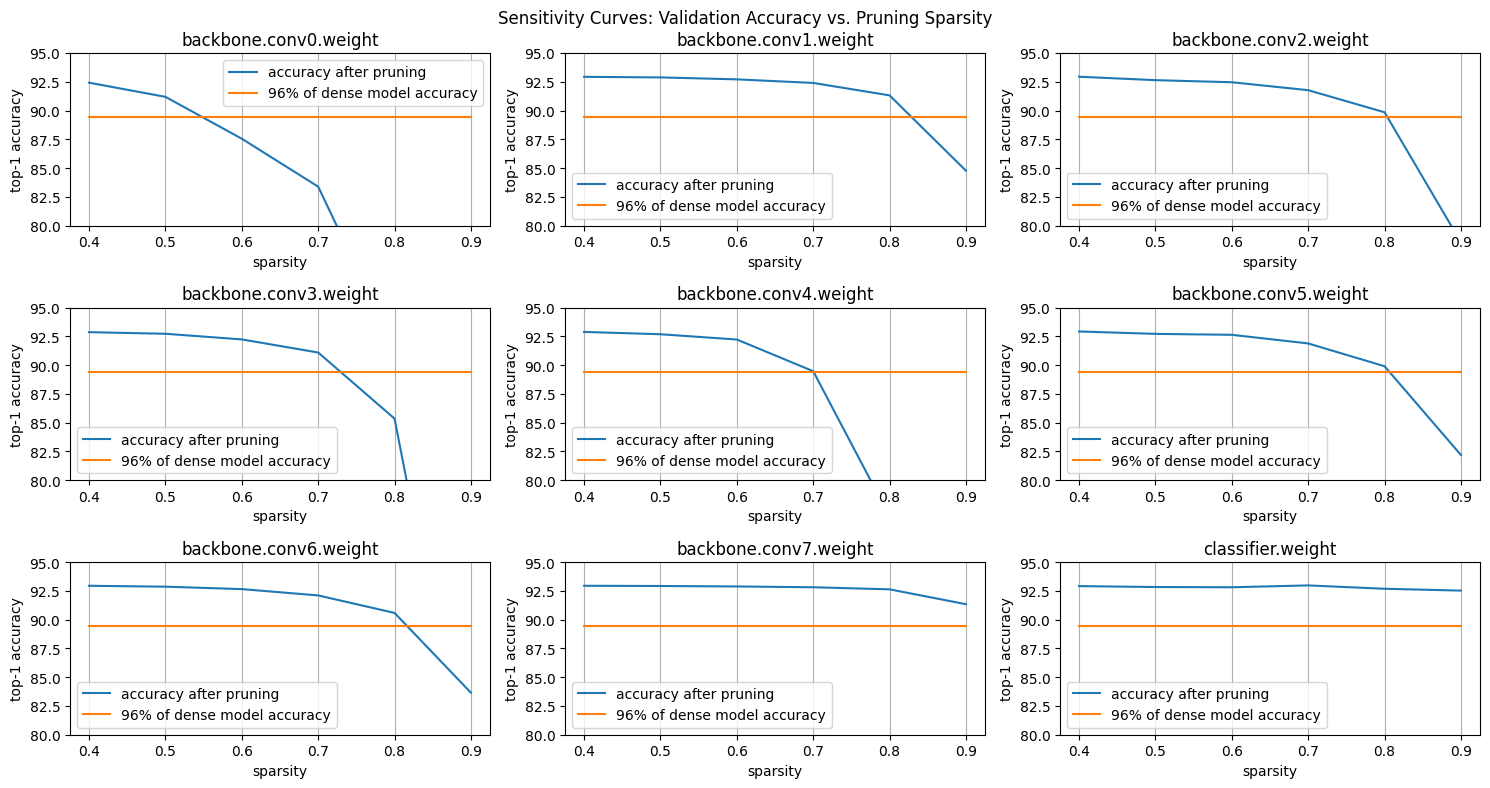

In [20]:
def plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy):
    lower_bound_accuracy = 100 - (100 - dense_model_accuracy) * 1.5
    fig, axes = plt.subplots(3, int(math.ceil(len(accuracies) / 3)),figsize=(15,8))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            curve = ax.plot(sparsities, accuracies[plot_index])
            line = ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities))
            ax.set_xticks(np.arange(start=0.4, stop=1.0, step=0.1))
            ax.set_ylim(80, 95)
            ax.set_title(name)
            ax.set_xlabel('sparsity')
            ax.set_ylabel('top-1 accuracy')
            ax.legend([
                'accuracy after pruning',
                f'{lower_bound_accuracy / dense_model_accuracy * 100:.0f}% of dense model accuracy'
            ])
            ax.grid(axis='x')
            plot_index += 1
    fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy)

#### Parameters of each layer
The number of each layer's parameters also affects the decision on sparsity selection. Layers with more #parametrs require larger sparsities.

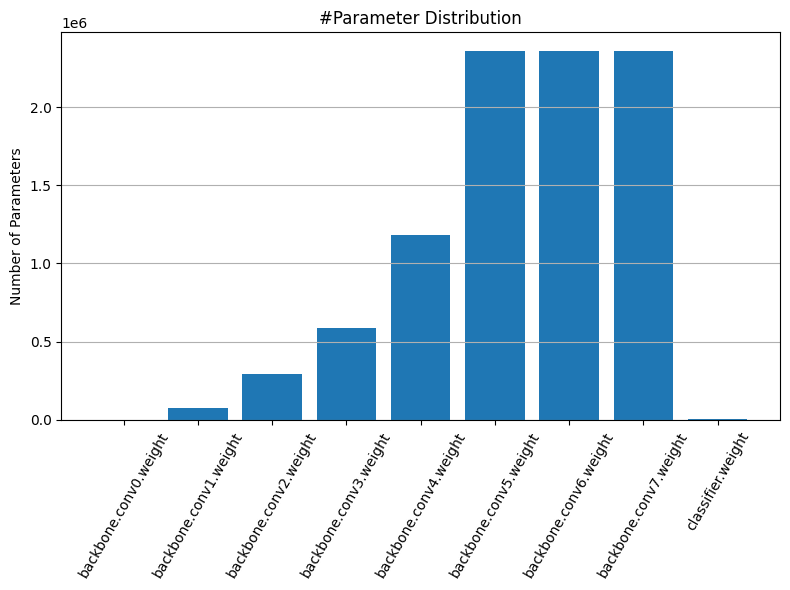

In [21]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(model)

#### Selecting sparsity based on sensitivity curves and parameters distribution

In [22]:
recover_model()

sparsity_dict = {
    'backbone.conv0.weight': 0.5,
    'backbone.conv1.weight': 0.8,
    'backbone.conv2.weight': 0.8,
    'backbone.conv3.weight': 0.7,
    'backbone.conv4.weight': 0.7,
    'backbone.conv5.weight': 0.8,
    'backbone.conv6.weight': 0.8,
    'backbone.conv7.weight': 0.9,
    'classifier.weight': 0.9
}

After pruning with sparsity dictionary
  backbone.conv0.weight: 0.50
  backbone.conv1.weight: 0.80
  backbone.conv2.weight: 0.80
  backbone.conv3.weight: 0.70
  backbone.conv4.weight: 0.70
  backbone.conv5.weight: 0.80
  backbone.conv6.weight: 0.80
  backbone.conv7.weight: 0.90
  classifier.weight: 0.90
The sparsity of each layer becomes
  backbone.conv0.weight: 0.50
  backbone.conv1.weight: 0.80
  backbone.conv2.weight: 0.80
  backbone.conv3.weight: 0.70
  backbone.conv4.weight: 0.70
  backbone.conv5.weight: 0.80
  backbone.conv6.weight: 0.80
  backbone.conv7.weight: 0.90
  classifier.weight: 0.90
Sparse model has size=6.83 MiB = 19.41% of dense model size


Sparse model has accuracy=66.84% before fintuning


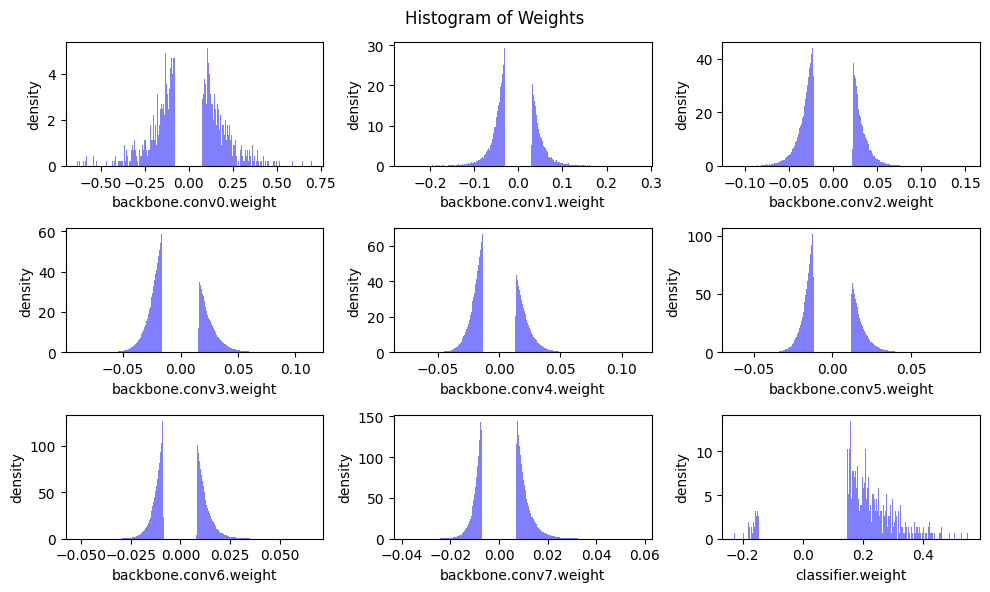

In [23]:
pruner = FineGrainedPruner(model, sparsity_dict)
print(f'After pruning with sparsity dictionary')
for name, sparsity in sparsity_dict.items():
    print(f'  {name}: {sparsity:.2f}')
print(f'The sparsity of each layer becomes')
for name, param in model.named_parameters():
    if name in sparsity_dict:
        print(f'  {name}: {get_sparsity(param):.2f}')

sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before fintuning")

plot_weight_distribution(model, count_nonzero_only=True)

#### Finetuning the fine-grained pruned model

In [24]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_sparse_model_checkpoint = dict()
best_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    # At the end of each train iteration, we have to apply the pruning mask
    #    to keep the model sparse during the training
    train(model, dataloader['train'], criterion, optimizer, scheduler,
          callbacks=[lambda: pruner.apply(model)])
    accuracy = evaluate(model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_sparse_model_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_accuracy = accuracy
    print(f'    Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

Finetuning Fine-grained Pruned Sparse Model


    Epoch 1 Accuracy 91.96% / Best Accuracy: 91.96%


train:   0%|                                                                                 | 0/98 [00:00<?, ?it/s]/home/ppst/Documents/agh/nn_pruning/.venv/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 1.33 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


    Epoch 2 Accuracy 92.27% / Best Accuracy: 92.27%


    Epoch 3 Accuracy 92.28% / Best Accuracy: 92.28%


    Epoch 4 Accuracy 92.46% / Best Accuracy: 92.46%


    Epoch 5 Accuracy 92.45% / Best Accuracy: 92.46%


In [25]:
# load the best sparse model checkpoint to evaluate the final performance
model.load_state_dict(best_sparse_model_checkpoint['state_dict'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% after fintuning")

Sparse model has size=6.83 MiB = 19.41% of dense model size


Sparse model has accuracy=92.46% after fintuning


### Channel Pruning
Channel pruning removes an entire channel, so that it can achieve inference speed up on existing hardware like GPUs. Similarly, we remove the channel whose weights are of smaller magnitueds (measured by Frobenius norm).

#### Removing channel weights
Unline fine-grained pruning, we can remove the weights entirely from the tensor in channel pruning. That is to say, the number of output channels is reduced:

> $\#\mathrm{out\_channels}_{\mathrm{new}} = \#\mathrm{out\_channels}_{\mathrm{origin}} \cdot (1 - \mathrm{sparsity})$

The weight tensor $W$ is still dense after channel pruning. Thus, we will refer to *sparsity* as ***prune ratio***.

Like fine-grained pruning, we can use different pruning rates for different layers. However, we use a uniform pruning rate for all the layers for now. We are targeting 2x computation reduction, which is roughly 30% uniform pruning rate (think about why).

In [35]:
def get_num_channels_to_keep(channels: int, prune_ratio: float) -> int:
    """A function to calculate the number of layers to PRESERVE after pruning
    Note that preserve_rate = 1. - prune_ratio
    """
    return int(round(channels * (1. - prune_ratio)))

@torch.no_grad()
def channel_prune(model: nn.Module,
                  prune_ratio: Union[List, float]) -> nn.Module:
    """Apply channel pruning to each of the conv layer in the backbone
    Note that for prune_ratio, we can either provide a floating-point number,
    indicating that we use a uniform pruning rate for all layers, or a list of
    numbers to indicate per-layer pruning rate.
    """
    # sanity check of provided prune_ratio
    assert isinstance(prune_ratio, (float, list))
    n_conv = len([m for m in model.backbone if isinstance(m, nn.Conv2d)])
    # note that for the ratios, it affects the previous conv output and next
    # conv input, i.e., conv0 - ratio0 - conv1 - ratio1-...
    if isinstance(prune_ratio, list):
        assert len(prune_ratio) == n_conv - 1
    else:  # convert float to list
        prune_ratio = [prune_ratio] * (n_conv - 1)

    # we prune the convs in the backbone with a uniform ratio
    model = copy.deepcopy(model)  # prevent overwrite
    # we only apply pruning to the backbone features
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]
    # apply pruning. we naively keep the first k channels
    assert len(all_convs) == len(all_bns)
    for i_ratio, p_ratio in enumerate(prune_ratio):
        prev_conv = all_convs[i_ratio]
        prev_bn = all_bns[i_ratio]
        next_conv = all_convs[i_ratio + 1]
        original_channels = prev_conv.out_channels  # same as next_conv.in_channels
        n_keep = get_num_channels_to_keep(original_channels, p_ratio)
        print(n_keep)

        # prune the output of the previous conv and bn
        prev_conv.weight.set_(prev_conv.weight.detach()[:n_keep])
        prev_bn.weight.set_(prev_bn.weight.detach()[:n_keep])
        prev_bn.bias.set_(prev_bn.bias.detach()[:n_keep])
        prev_bn.running_mean.set_(prev_bn.running_mean.detach()[:n_keep])
        prev_bn.running_var.set_(prev_bn.running_var.detach()[:n_keep])

        # prune the input of the next conv (hint: just one line of code)
        next_conv.weight.set_(next_conv.weight.detach()[:, :n_keep])

    return model


In [27]:
dummy_input = torch.randn(1, 3, 32, 32).cuda()
pruned_model = channel_prune(model, prune_ratio=0.3)
pruned_macs = get_model_macs(pruned_model, dummy_input)
assert pruned_macs == 305388064
print('* Check passed. Right MACs for the pruned model.')

45
90
179
179
358
358
358
* Check passed. Right MACs for the pruned model.


In [28]:
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")

pruned model has accuracy=19.71%


#### Ranking Channels by Importance

As you can see, removing the first 30% of channels in all layers leads to significant accuracy reduction. One potential method to remedy the issue is to find the **less important** channel weights to remove. A popular criterion for importance is to use the Frobenius norm of the weights corresponding to each input channel:

> $importance_{i} = \|W_{i}\|_2, \;\; i = 0, 1, 2,\cdots, \#\mathrm{in\_channels}-1$

We can sort the channel weights from more important to less important, and then keep the frst $k$ channels for each layer.


In [34]:
# function to sort the channels from important to non-important
def get_input_channel_importance(weight):
    in_channels = weight.shape[1]
    importances = []
    # compute the importance for each input channel
    for i_c in range(weight.shape[1]):
        channel_weight = weight.detach()[:, i_c]
        importance = torch.linalg.norm(channel_weight)
        importances.append(importance.view(1))
    return torch.cat(importances)

@torch.no_grad()
def apply_channel_sorting(model):
    model = copy.deepcopy(model)  # do not modify the original model
    # fetch all the conv and bn layers from the backbone
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]
    # iterate through conv layers
    for i_conv in range(len(all_convs) - 1):
        # each channel sorting index, we need to apply it to:
        # - the output dimension of the previous conv
        # - the previous BN layer
        # - the input dimension of the next conv (we compute importance here)
        prev_conv = all_convs[i_conv]
        prev_bn = all_bns[i_conv]
        next_conv = all_convs[i_conv + 1]
        # note that we always compute the importance according to input channels
        importance = get_input_channel_importance(next_conv.weight)
        # sorting from large to small
        sort_idx = torch.argsort(importance, descending=True)

        # apply to previous conv and its following bn
        prev_conv.weight.copy_(torch.index_select(
            prev_conv.weight.detach(), 0, sort_idx))
        for tensor_name in ['weight', 'bias', 'running_mean', 'running_var']:
            tensor_to_apply = getattr(prev_bn, tensor_name)
            tensor_to_apply.copy_(
                torch.index_select(tensor_to_apply.detach(), 0, sort_idx)
            )

        # apply to the next conv input (hint: one line of code)
        next_conv.weight.copy_(torch.index_select(next_conv.weight.detach(), 1, sort_idx))

    return model

In [30]:
print('Before sorting...')
dense_model_accuracy = evaluate(model, dataloader['test'])
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

print('After sorting...')
sorted_model = apply_channel_sorting(model)
sorted_model_accuracy = evaluate(sorted_model, dataloader['test'])
print(f"sorted model has accuracy={sorted_model_accuracy:.2f}%")

# make sure accuracy does not change after sorting, since it is
# equivalent transform
assert abs(sorted_model_accuracy - dense_model_accuracy) < 0.1
print('* Check passed.')

Before sorting...


dense model has accuracy=92.46%
After sorting...


sorted model has accuracy=92.46%
* Check passed.


In [31]:
channel_pruning_ratio = 0.3  # pruned-out ratio

print(" * Without sorting...")
pruned_model = channel_prune(model, channel_pruning_ratio)
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


print(" * With sorting...")
sorted_model = apply_channel_sorting(model)
pruned_model = channel_prune(sorted_model, channel_pruning_ratio)
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


 * Without sorting...
45
90
179
179
358
358
358


pruned model has accuracy=19.71%
 * With sorting...
45
90
179
179
358
358
358


pruned model has accuracy=40.89%


In [32]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(pruned_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_accuracy = 0
for epoch in range(num_finetune_epochs):
    train(pruned_model, dataloader['train'], criterion, optimizer, scheduler)
    accuracy = evaluate(pruned_model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_accuracy = accuracy
    print(f'Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

Epoch 1 Accuracy 91.52% / Best Accuracy: 91.52%


Epoch 2 Accuracy 91.74% / Best Accuracy: 91.74%


Epoch 3 Accuracy 92.03% / Best Accuracy: 92.03%


Epoch 4 Accuracy 92.04% / Best Accuracy: 92.04%


Epoch 5 Accuracy 92.10% / Best Accuracy: 92.10%


#### Measuring acceleration from pruning

In [33]:
# helper functions to measure latency of a regular PyTorch models.
#   Unlike fine-grained pruning, channel pruning
#   can directly leads to model size reduction and speed up.
@torch.no_grad()
def measure_latency(model, dummy_input, n_warmup=20, n_test=100):
    model.eval()
    # warmup
    for _ in range(n_warmup):
        _ = model(dummy_input)
    # real test
    t1 = time.time()
    for _ in range(n_test):
        _ = model(dummy_input)
    t2 = time.time()
    return (t2 - t1) / n_test  # average latency

table_template = "{:<15} {:<15} {:<15} {:<15}"
print (table_template.format('', 'Original','Pruned','Reduction Ratio'))

# 1. measure the latency of the original model and the pruned model on CPU
#   which simulates inference on an edge device
dummy_input = torch.randn(1, 3, 32, 32).to('cpu')
pruned_model = pruned_model.to('cpu')
model = model.to('cpu')

pruned_latency = measure_latency(pruned_model, dummy_input)
original_latency = measure_latency(model, dummy_input)
print(table_template.format('Latency (ms)',
                            round(original_latency * 1000, 1),
                            round(pruned_latency * 1000, 1),
                            round(original_latency / pruned_latency, 1)))

# 2. measure the computation (MACs)
original_macs = get_model_macs(model, dummy_input)
pruned_macs = get_model_macs(pruned_model, dummy_input)
print(table_template.format('MACs (M)',
                            round(original_macs / 1e6),
                            round(pruned_macs / 1e6),
                            round(original_macs / pruned_macs, 1)))

# 3. measure the model size (params)
original_param = get_num_parameters(model)
pruned_param = get_num_parameters(pruned_model)
print(table_template.format('Param (M)',
                            round(original_param / 1e6, 2),
                            round(pruned_param / 1e6, 2),
                            round(original_param / pruned_param, 1)))

# put model back to cuda
pruned_model = pruned_model.to('cuda')
model = model.to('cuda')

                Original        Pruned          Reduction Ratio
Latency (ms)    7.5             5.0             1.5            
MACs (M)        606             305             2.0            
Param (M)       9.23            5.01            1.8            


## torch.ao pruning
In this section the (PyTorch Architecture Optimization library)[https://github.com/pytorch/ao] is used to perform pruning on the model. The results from torch.ao and techniques presented in the EfficientML course will be compared.

### Setup

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
import torch.nn as nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from torchvision.models import vgg16
from tqdm.auto import tqdm

# Ensure CUDA support
assert torch.cuda.is_available(), "The runtime has no CUDA support"

/home/ppst/Documents/agh/nn_pruning/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# setting seeds for reproducability
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [3]:
def download_url(url, model_dir='.', overwrite=False):
    import os, sys, ssl
    from urllib.request import urlretrieve
    ssl._create_default_https_context = ssl._create_unverified_context
    target_dir = url.split('/')[-1]
    model_dir = os.path.expanduser(model_dir)
    try:
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        model_dir = os.path.join(model_dir, target_dir)
        cached_file = model_dir
        if not os.path.exists(cached_file) or overwrite:
            sys.stderr.write('Downloading: "{}" to {}\n'.format(url, cached_file))
            urlretrieve(url, cached_file)
        return cached_file
    except Exception as e:
        # remove lock file so download can be executed next time.
        os.remove(os.path.join(model_dir, 'download.lock'))
        sys.stderr.write('Failed to download from url %s' % url + '\n' + str(e) + '\n')
        return None

In [4]:
class VGG(nn.Module):
  ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
  # ARCH =  [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"]

  def __init__(self) -> None:
    super().__init__()

    layers = []
    counts = defaultdict(int)

    def add(name: str, layer: nn.Module) -> None:
      layers.append((f"{name}{counts[name]}", layer))
      counts[name] += 1

    in_channels = 3
    for x in self.ARCH:
      if x != 'M':
        # conv-bn-relu
        add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
        add("bn", nn.BatchNorm2d(x))
        add("relu", nn.ReLU(True))
        in_channels = x
      else:
        # maxpool
        add("pool", nn.MaxPool2d(2))

    self.backbone = nn.Sequential(OrderedDict(layers))
    self.classifier = nn.Linear(512, 10)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
    x = self.backbone(x)

    # avgpool: [N, 512, 2, 2] => [N, 512]
    # x = x.mean([2, 3])
    x = torch.mean(x, [2,3])

    # classifier: [N, 512] => [N, 10]
    x = self.classifier(x)
    return x

In [5]:
model = VGG().cuda()

In [6]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

In [7]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

Helper Functions (Flops, Model Size calculation, etc.)

In [8]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

Define misc functions for verification.

In [9]:
def test_fine_grained_prune(
    test_tensor=torch.tensor([[-0.46, -0.40, 0.39, 0.19, 0.37],
                              [0.00, 0.40, 0.17, -0.15, 0.16],
                              [-0.20, -0.23, 0.36, 0.25, 0.03],
                              [0.24, 0.41, 0.07, 0.13, -0.15],
                              [0.48, -0.09, -0.36, 0.12, 0.45]]),
    test_mask=torch.tensor([[True, True, False, False, False],
                            [False, True, False, False, False],
                            [False, False, False, False, False],
                            [False, True, False, False, False],
                            [True, False, False, False, True]]),
    target_sparsity=0.75, target_nonzeros=None):
    def plot_matrix(tensor, ax, title):
        ax.imshow(tensor.cpu().numpy() == 0, vmin=0, vmax=1, cmap='tab20c')
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[1]):
            for j in range(tensor.shape[0]):
                text = ax.text(j, i, f'{tensor[i, j].item():.2f}',
                                ha="center", va="center", color="k")

    test_tensor = test_tensor.clone()
    fig, axes = plt.subplots(1,2, figsize=(6, 10))
    ax_left, ax_right = axes.ravel()
    plot_matrix(test_tensor, ax_left, 'dense tensor')

    sparsity_before_pruning = get_sparsity(test_tensor)
    mask = fine_grained_prune(test_tensor, target_sparsity)
    sparsity_after_pruning = get_sparsity(test_tensor)
    sparsity_of_mask = get_sparsity(mask)

    plot_matrix(test_tensor, ax_right, 'sparse tensor')
    fig.tight_layout()
    plt.show()

    print('* Test fine_grained_prune()')
    print(f'    target sparsity: {target_sparsity:.2f}')
    print(f'        sparsity before pruning: {sparsity_before_pruning:.2f}')
    print(f'        sparsity after pruning: {sparsity_after_pruning:.2f}')
    print(f'        sparsity of pruning mask: {sparsity_of_mask:.2f}')

    if target_nonzeros is None:
        if test_mask.equal(mask):
            print('* Test passed.')
        else:
            print('* Test failed.')
    else:
        if mask.count_nonzero() == target_nonzeros:
            print('* Test passed.')
        else:
            print('* Test failed.')

Load the pretrained model and the CIFAR-10 dataset.

In [10]:
checkpoint_url = "https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth"
checkpoint = torch.load(download_url(checkpoint_url), map_location="cpu")
model = VGG().cuda()
print(f"=> loading checkpoint '{checkpoint_url}'")
model.load_state_dict(checkpoint['state_dict'])
recover_model = lambda: model.load_state_dict(checkpoint['state_dict'])

=> loading checkpoint 'https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth'


In [11]:
image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": ToTensor(),
}
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

Files already downloaded and verified
Files already downloaded and verified


### Dense model accuracy and model size

In [ ]:
model

In [127]:
original_model = copy.deepcopy(model)

In [123]:
dense_model_accuracy = evaluate(model, dataloader['test'])
dense_model_size = get_model_size(model)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")

dense model has accuracy=92.95%
dense model has size=35.20 MiB


### Weight value distribution

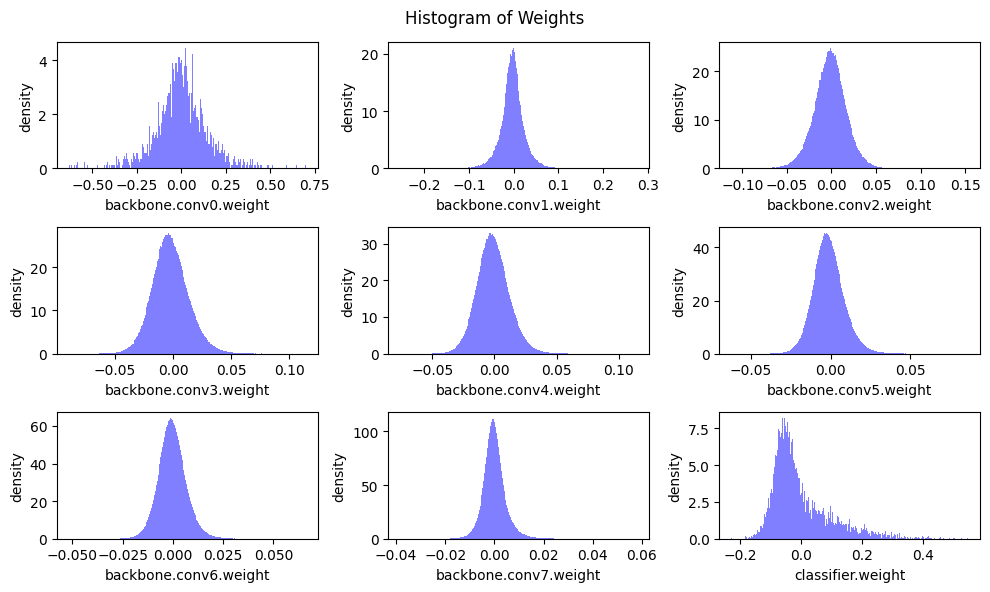

In [70]:
import matplotlib.pyplot as plt
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(3,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_weight_distribution(model)

### Pruning functions

In [128]:
import torch
from torch.sparse import to_sparse_semi_structured, SparseSemiStructuredTensor
from torch.ao.pruning import WeightNormSparsifier, BaseSparsifier
from torch.ao.pruning._experimental.pruner import SaliencyPruner
from torch.ao.pruning._experimental.pruner.base_structured_sparsifier import _get_default_structured_pruning_patterns
from torch.ao.pruning._experimental.pruner.prune_functions import prune_conv2d
from typing import Optional, Callable
from torch import Tensor

from typing import cast, List, Optional, Callable, Tuple

import torch
from torch import nn, Tensor
from torch.nn.utils import parametrize
from torch.nn.utils.parametrize import ParametrizationList
from torch.ao.pruning._experimental.pruner.parametrization import FakeStructuredSparsity, BiasHook
from torch.ao.pruning._experimental.pruner.prune_functions import _prune_conv2d_helper, _propogate_module_bias, prune_linear

def prune_conv2d_bn_act_conv2d(
    conv2d_1: nn.Conv2d,
    bn: nn.BatchNorm2d,
    activation: Optional[Callable[[Tensor], Tensor]],
    conv2d_2: nn.Conv2d
) -> None:
    r"""
    Fusion Pattern for conv2d -> bn2d -> some activation module / function -> conv2d layers
    """
    print('c1_bn_act_c2')
    parametrization_dict = cast(nn.ModuleDict, conv2d_1.parametrizations)
    weight_parameterizations = cast(ParametrizationList, parametrization_dict.weight)
    for p in weight_parameterizations:
        if isinstance(p, FakeStructuredSparsity):
            mask = cast(Tensor, p.mask)

    prune_bias = getattr(conv2d_1, "prune_bias", False)
    if (
        hasattr(conv2d_2, "padding")
        and cast(Tuple[int], conv2d_2.padding) > (0, 0)
        and (conv2d_1.bias is not None or getattr(conv2d_1, "_bias", None) is not None)
    ):
        prune_conv2d_padded(conv2d_1)
    else:
        mask = _prune_conv2d_helper(conv2d_1)
        if prune_bias:
            _prune_module_bias(conv2d_1, mask)
        else:
            pruned_biases = _propogate_module_bias(conv2d_1, mask)
            if pruned_biases is not None:
                if activation:
                    pruned_biases = activation(pruned_biases)
                conv2d_2.bias = _get_adjusted_next_layer_bias(
                    conv2d_2, pruned_biases, mask
                )

        if (
            not (
                hasattr(conv2d_2, "padding")
                and cast(Tuple[int], conv2d_2.padding) > (0, 0)
            )
            or conv2d_1.bias is None
        ):
            with torch.no_grad():
                if parametrize.is_parametrized(conv2d_2):
                    parametrization_dict = cast(
                        nn.ModuleDict, conv2d_2.parametrizations
                    )
                    weight_parameterizations = cast(
                        ParametrizationList, parametrization_dict.weight
                    )
                    weight_parameterizations.original = nn.Parameter(
                        weight_parameterizations.original[:, mask]
                    )
                    conv2d_2.in_channels = weight_parameterizations.original.shape[1]
                else:
                    conv2d_2.weight = nn.Parameter(conv2d_2.weight[:, mask])
                    conv2d_2.in_channels = conv2d_2.weight.shape[1]
                bn.weight = nn.Parameter(bn.weight[mask].detach())
                bn.bias = nn.Parameter(bn.bias[mask].detach())
                bn.running_mean = bn.running_mean[mask]
                bn.running_var = bn.running_var[mask]
                bn.num_features = bn.weight.shape[0]

def prune_conv2d_bn_act_pool_conv2d(
    c1: nn.Conv2d,
    bn: nn.BatchNorm2d,
    activation: Optional[Callable[[Tensor], Tensor]],
    pool: nn.Module,
    c2: nn.Conv2d
) -> None:
    prune_conv2d_bn_act_conv2d(c1, bn, activation, c2)
    
def prune_conv2d_bn_act_pool_classifier(
    conv2d_1: nn.Conv2d,
    bn: nn.BatchNorm2d,
    activation: Optional[Callable[[Tensor], Tensor]],
    pool: nn.Module,
    mean: Optional[Callable[[Tensor], Tensor]],
    linear: nn.Linear
) -> None:
    print('c1_bn_act_pool_l1')
    parametrization_dict = cast(nn.ModuleDict, conv2d_1.parametrizations)
    weight_parameterizations = cast(ParametrizationList, parametrization_dict.weight)
    for p in weight_parameterizations:
        if isinstance(p, FakeStructuredSparsity):
            mask = cast(Tensor, p.mask)

    prune_bias = getattr(conv2d_1, "prune_bias", False)
    if (
        hasattr(linear, "padding")
        and cast(Tuple[int], linear.padding) > (0, 0)
        and (conv2d_1.bias is not None or getattr(conv2d_1, "_bias", None) is not None)
    ):
        prune_conv2d_padded(conv2d_1)
    else:
        mask = _prune_conv2d_helper(conv2d_1)
        if prune_bias:
            _prune_module_bias(conv2d_1, mask)
        else:
            pruned_biases = _propogate_module_bias(conv2d_1, mask)
            if pruned_biases is not None:
                if activation:
                    pruned_biases = activation(pruned_biases)
                linear.bias = _get_adjusted_next_layer_bias(
                    linear, pruned_biases, mask
                )

        if (
            not (
                hasattr(linear, "padding")
                and cast(Tuple[int], linear.padding) > (0, 0)
            )
            or conv2d_1.bias is None
        ):
            with torch.no_grad():
                if parametrize.is_parametrized(linear):
                    parametrization_dict = cast(
                        nn.ModuleDict, linear.parametrizations
                    )
                    weight_parameterizations = cast(
                        ParametrizationList, parametrization_dict.weight
                    )
                    weight_parameterizations.original = nn.Parameter(
                        weight_parameterizations.original[:, mask]
                    )
                    linear.in_features = weight_parameterizations.original.shape[1]
                    prune_linear(linear)
                else:
                    linear.weight = nn.Parameter(linear.weight[:, mask])
                    linear.in_features = linear.weight.shape[1]
                bn.weight = nn.Parameter(bn.weight[mask].detach())
                bn.bias = nn.Parameter(bn.bias[mask].detach())
                bn.running_mean = bn.running_mean[mask]
                bn.running_var = bn.running_var[mask]
                bn.num_features = bn.weight.shape[0]

    
# note how the pattern defined in the key will be passed to the pruning function as args
my_patterns = {
    (nn.Conv2d, nn.BatchNorm2d, nn.ReLU, nn.Conv2d): prune_conv2d_bn_act_conv2d,
    (nn.Conv2d, nn.BatchNorm2d, nn.ReLU, nn.MaxPool2d, nn.Conv2d): prune_conv2d_bn_act_pool_conv2d,
    (nn.Conv2d, nn.BatchNorm2d, nn.ReLU, nn.MaxPool2d, torch.mean, nn.Linear): prune_conv2d_bn_act_pool_classifier,
    }

pruning_patterns = _get_default_structured_pruning_patterns()
pruning_patterns.update(my_patterns)

defaults = {'prune_bias': True}
pruner = SaliencyPruner(defaults, patterns=my_patterns)

### Sensitivity scan

In [103]:
import copy

layer_list = [
    'backbone.conv0.weight',
    'backbone.conv1.weight',    
    'backbone.conv2.weight',    
    'backbone.conv3.weight',
    'backbone.conv4.weight',
    'backbone.conv5.weight',
    'backbone.conv6.weight',    
    'backbone.conv7.weight'
]

@torch.no_grad()
def channel_sensitivity_scan(model, pruner, layer_list, dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    model_copy = copy.deepcopy(model)
    # pruner_copy = copy.deepcopy(pruner)
    for layer in layer_list:
        accuracy = []
        for sparsity in sparsities:
            config = [{'tensor_fqn': layer, 'sparsity_level': sparsity}]
            pruner.prepare(model, config)
            pruner.enable_mask_update = True
            pruner.step()
            model = pruner.prune()
            accuracy.append(evaluate(model, dataloader))
            
            model = copy.deepcopy(model_copy)
            # pruner = copy.deepcopy(pruner_copy)
        accuracies.append(accuracy)
    
    return sparsities, accuracies


In [104]:
sparsities, accuracies = channel_sensitivity_scan(
    model, pruner, layer_list, dataloader['test'], scan_step=0.1, scan_start=0.1, scan_end=0.7)

c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


eval:   0%|                                                                                                                                                                                                      | 0/20 [00:00<?, ?it/s]/home/ppst/Documents/agh/nn_pruning/.venv/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 816.00 MiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_c2


c1_bn_act_pool_l1


c1_bn_act_pool_l1


c1_bn_act_pool_l1


c1_bn_act_pool_l1


c1_bn_act_pool_l1


c1_bn_act_pool_l1


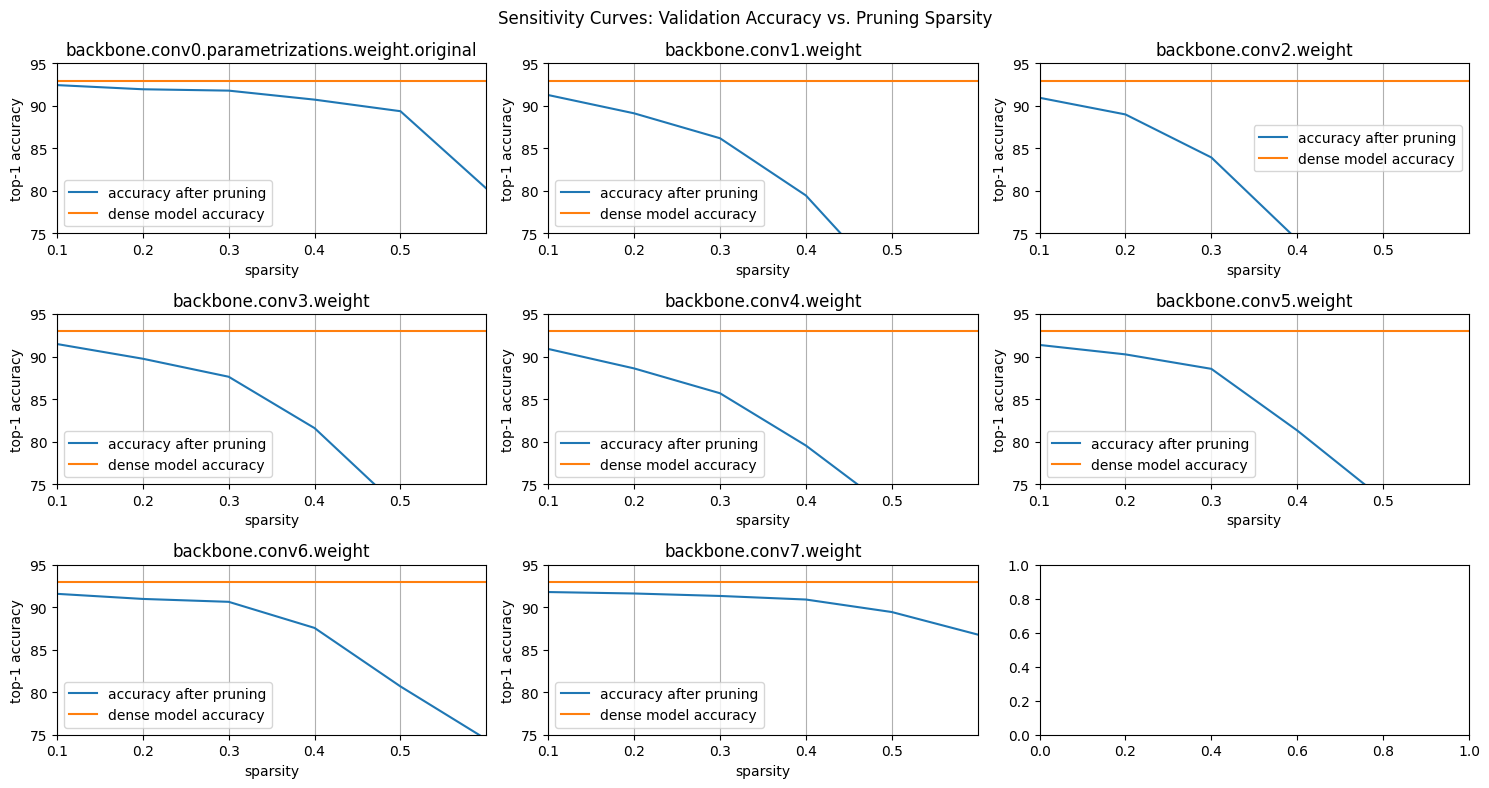

In [105]:
import matplotlib.pyplot as plt

def plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy):
    # lower_bound_accuracy = 100 - (100 - dense_model_accuracy) * 1.5
    fig, axes = plt.subplots(3, int(math.ceil(len(accuracies) / 3)),figsize=(15,8))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        # if param.dim() > 1:
        if param.dim() > 1 and plot_index < 8:
            ax = axes[plot_index]
            curve = ax.plot(sparsities, accuracies[plot_index])
            line = ax.plot(sparsities, [dense_model_accuracy] * len(sparsities))
            ax.set_xticks(np.arange(start=sparsities[0], stop=sparsities[-1], step=0.1))
            ax.set_ylim(75, 95)
            ax.set_xlim(sparsities[0], sparsities[-1])
            ax.set_title(name)
            ax.set_xlabel('sparsity')
            ax.set_ylabel('top-1 accuracy')
            ax.legend(['accuracy after pruning', 'dense model accuracy'])
            ax.grid(axis='x')
            plot_index += 1
    fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity')
    fig.tight_layout()
    # fig.subplots_adjust(top=0.925)
    plt.show()

plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy)


### Pruning

Save model copy

In [96]:
import copy
original_model = copy.deepcopy(model)
original_model

VGG(
  (backbone): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (pool1): MaxPo

In [128]:
model = copy.deepcopy(original_model)

In [129]:
from torch.fx import symbolic_trace
traced = symbolic_trace(model)
list(traced.graph.nodes)

[x,
 backbone_conv0,
 backbone_bn0,
 backbone_relu0,
 backbone_conv1,
 backbone_bn1,
 backbone_relu1,
 backbone_pool0,
 backbone_conv2,
 backbone_bn2,
 backbone_relu2,
 backbone_conv3,
 backbone_bn3,
 backbone_relu3,
 backbone_pool1,
 backbone_conv4,
 backbone_bn4,
 backbone_relu4,
 backbone_conv5,
 backbone_bn5,
 backbone_relu5,
 backbone_pool2,
 backbone_conv6,
 backbone_bn6,
 backbone_relu6,
 backbone_conv7,
 backbone_bn7,
 backbone_relu7,
 backbone_pool3,
 mean,
 classifier,
 output]

In [130]:
traced.graph.print_tabular()

opcode         name            target                                                   args                      kwargs
-------------  --------------  -------------------------------------------------------  ------------------------  --------
placeholder    x               x                                                        ()                        {}
call_module    backbone_conv0  backbone.conv0                                           (x,)                      {}
call_module    backbone_bn0    backbone.bn0                                             (backbone_conv0,)         {}
call_module    backbone_relu0  backbone.relu0                                           (backbone_bn0,)           {}
call_module    backbone_conv1  backbone.conv1                                           (backbone_relu0,)         {}
call_module    backbone_bn1    backbone.bn1                                             (backbone_conv1,)         {}
call_module    backbone_relu1  backbone.relu1         

In [137]:
model = copy.deepcopy(original_model)

sparse_config = [
    {'tensor_fqn': 'backbone.conv0.weight', 'sparsity_level': 0.5},
    {'tensor_fqn': 'backbone.conv1.weight', 'sparsity_level': 0.2},
    {'tensor_fqn': 'backbone.conv2.weight', 'sparsity_level': 0.2},
    {'tensor_fqn': 'backbone.conv3.weight', 'sparsity_level': 0.3},
    {'tensor_fqn': 'backbone.conv4.weight', 'sparsity_level': 0.2},
    {'tensor_fqn': 'backbone.conv5.weight', 'sparsity_level': 0.3},
    {'tensor_fqn': 'backbone.conv6.weight', 'sparsity_level': 0.4},
    {'tensor_fqn': 'backbone.conv7.weight', 'sparsity_level': 0.6},
    # {'tensor_fqn': 'classifier.weight', 'sparsity_level': 0.9} # no sparsity for the classifier, as this would apply it to the output.
]

pruner.prepare(model, sparse_config)
pruner.enable_mask_update = True
pruner.step()

In [138]:
pruned_model = pruner.prune()

c1_bn_act_c2
c1_bn_act_c2
c1_bn_act_c2
c1_bn_act_c2
c1_bn_act_c2
c1_bn_act_c2
c1_bn_act_c2
c1_bn_act_pool_l1


Sparse model has size=15.68 MiB = 44.54% of dense model size


Sparse model has accuracy=37.58% before fintuning


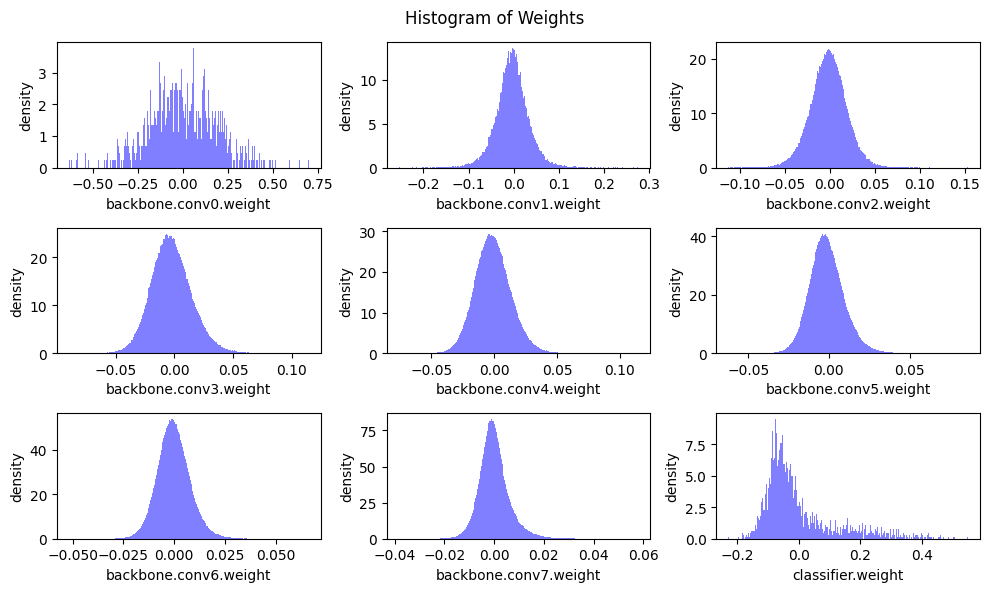

In [139]:
dense_model_size = get_model_size(original_model, count_nonzero_only=True)
pruned_model_size = get_model_size(pruned_model, count_nonzero_only=True)
print(f"Sparse model has size={pruned_model_size / MiB:.2f} MiB = {pruned_model_size / dense_model_size * 100:.2f}% of dense model size")
pruned_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={pruned_model_accuracy:.2f}% before fintuning")

plot_weight_distribution(model, count_nonzero_only=True)

In [140]:
original_model

VGG(
  (backbone): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (pool1): MaxPo

In [141]:
pruned_model

VGG(
  (backbone): Module(
    (conv0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (conv1): Conv2d(32, 103, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(103, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(103, 205, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(205, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(205, 180, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(180, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (pool1): MaxPool2d

### Fine-tune

In [142]:
num_finetune_epochs = 5
optimizer = torch.optim.Adam(pruned_model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_accuracy = 0
for epoch in range(num_finetune_epochs):
    train(pruned_model, dataloader['train'], criterion, optimizer, scheduler)
    accuracy = evaluate(pruned_model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_accuracy = accuracy
    print(f'Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

Epoch 1 Accuracy 47.40% / Best Accuracy: 47.40%


Epoch 2 Accuracy 58.61% / Best Accuracy: 58.61%


Epoch 3 Accuracy 59.41% / Best Accuracy: 59.41%


Epoch 4 Accuracy 29.31% / Best Accuracy: 59.41%


Epoch 5 Accuracy 71.87% / Best Accuracy: 71.87%


In [144]:
# helper functions to measure latency of a regular PyTorch models.
#   Unlike fine-grained pruning, channel pruning
#   can directly leads to model size reduction and speed up.
@torch.no_grad()
def measure_latency(model, dummy_input, n_warmup=20, n_test=100):
    model.eval()
    # warmup
    for _ in range(n_warmup):
        _ = model(dummy_input)
    # real test
    t1 = time.time()
    for _ in range(n_test):
        _ = model(dummy_input)
    t2 = time.time()
    return (t2 - t1) / n_test  # average latency

table_template = "{:<15} {:<15} {:<15} {:<15}"
print (table_template.format('', 'Original','Pruned','Reduction Ratio'))

# 1. measure the latency of the original model and the pruned model on CPU
#   which simulates inference on an edge device
dummy_input = torch.randn(1, 3, 32, 32).to('cpu')
pruned_model = pruned_model.to('cpu')
original_model = original_model.to('cpu')

pruned_latency = measure_latency(pruned_model, dummy_input)
original_latency = measure_latency(original_model, dummy_input)
print(table_template.format('Latency (ms)',
                            round(original_latency * 1000, 1),
                            round(pruned_latency * 1000, 1),
                            round(original_latency / pruned_latency, 1)))

# 2. measure the computation (MACs)
original_macs = get_model_macs(original_model, dummy_input)
pruned_macs = get_model_macs(pruned_model, dummy_input)
print(table_template.format('MACs (M)',
                            round(original_macs / 1e6),
                            round(pruned_macs / 1e6),
                            round(original_macs / pruned_macs, 1)))

# 3. measure the model size (params)
original_param = get_num_parameters(original_model)
pruned_param = get_num_parameters(pruned_model)
print(table_template.format('Param (M)',
                            round(original_param / 1e6, 2),
                            round(pruned_param / 1e6, 2),
                            round(original_param / pruned_param, 1)))

# put model back to cuda
pruned_model = pruned_model.to('cuda')
original_model = original_model.to('cuda')

                Original        Pruned          Reduction Ratio
Latency (ms)    7.8             4.9             1.6            
MACs (M)        606             318             1.9            
Param (M)       9.23            4.11            2.2            
